Kyle Mckay - F21DL Coursework Portfolio
===

1. [Data Set Choice](#h1)
2. [Visualization and Initial Data Exploration](#h2)
    1. [Class Distribution](#h2_1)
    2. [Image Size Distribution](#h2_2)
    3. [Image Preprocessing](#h2_3)
    1. [Direct Comparison](#h2_4)
    2. [Conversion to Pixel Data](#h2_5)
    3. [Average Images](#h2_6)
    4. [Standard Deviation](#h2_7)
3. [Acknowledgement](#ack)

# Setup

In [1]:
%matplotlib inline
import os
import cv2
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Seed randomness for deterministic results when re-executing notebook
np.random.seed(332)

Initalise variables and functions used throughout the notebook

In [2]:
data_dir = 'DATA' 
img_dir = f'{data_dir}/images'

# Utility method to plot numpy greyscale pixel matrices side by side for comparison
def multi_plot(imgs, size=(10,10), rowlen=5):
    fig = plt.figure(figsize=size)

    rows = math.ceil(len(imgs) / rowlen)
    for i, cl in enumerate(imgs, 1):
        ax = fig.add_subplot(rows, rowlen, i)
        ax.imshow(imgs[cl], vmin=0, vmax=255, cmap='Greys_r')
        plt.title(cl)
        plt.axis('off')
    
    plt.show()

# <a id="h1">Data Set Choice</a>

I chose to work with the FGVC-Aircraft data set (Maji et al.) because:

- It is an image dataset and I'm interested in computer vision and image processing techniques.
- The data set is intended for use as a multiclass classification problem, which provides an interesting level of complexity above binary classification and below multi-label classification.
- There is granularity to the classes in the data set. With 41 manufacturers providing plenty of instances (image files) to work with for each.
- The images are not provided in a uniform size or aspect ratio, which adds some complexity to homogenising and reducing the data in preprocessing to meet computational constraints.
- The data provenance is clearly stated and acceptable for my research/learning purposes.

# <a id="h2">Visualization and Initial Data Exploration</a>

## <a id="h2_1">Class Distribution</a>

I first want to get a sense for the number of instances there are per manufacturer since I know there are 100 images per aircraft model (the highest level of granularity), but have no sense for how evenly distributed those are among the lower class granularity levels.

This is important since for training purposes I want my data to have an approximately even distribution to avoid biasing classification results.

In [3]:
# Data set provides text files listing the label that applies to each image
img_labels = pd.read_csv(
    f'{data_dir}/images_manufacturer_train.txt',
    sep=' ', header=None, 
    names=['image', 'class'],
    skip_blank_lines=True,
    # Image ID will be used as the index for row access
    index_col='image'
)
print(f'{img_labels.shape[0]} instances in the sample')
img_labels.head()

3334 instances in the sample


,class
image,
1025794,Boeing
1340192,Boeing
56978,Boeing
698580,Boeing
450014,Boeing


In [4]:
# Interested in classes with at least 100 instances (reasonable quantity)
class_counts = img_labels['class'].value_counts()
class_counts = class_counts[class_counts >= 100]
class_counts

Boeing       733
Airbus       434
Embraer      233
McDonnell    232
de           167
Canadair     134
British      133
Cessna       133
Douglas      133
Lockheed     102
Fokker       100
Name: class, dtype: int64

Evidently there is not an even distribution of the manufacturer classes. First I drop all the classes with an insufficient number of instances. This achieves two desired outcomes:

- I want a reasonable minimum amount of data to work with for each class to avoid underfitting the data.
- I want to reduce the overall number of classes to simplify things while learning and reduce the amount of data being processed to meet computational constraints.

I'll also want to drop instances of each class so that there's an even distribution, but to be smart about how I do that I first want to inspect the image sizes I'm working with.


In [5]:
# Only interested in images with sufficient number of class instances
all_imgs = img_labels.copy()
all_imgs = all_imgs[img_labels['class'].isin(class_counts.keys())]

## <a id="h2_2">Image Size Distribution</a>

I next want to get a sense for how homogeneous the images are in terms of their dimensions and aspect ratio. This is relevant to check if preprocessing needs to be done and, if so, which approach I will take.

In [6]:
# Scanning all image sizes is fairly slow, so results are saved for future runs
dims_csv = f'{data_dir}/images_dims.csv'
if (os.path.isfile(dims_csv)):
    img_sizes = pd.read_csv(dims_csv, index_col='image')
else:
    tmp = []
    for fn in all_imgs.index:
        # Image names are 0 padded to 7 digits
        img = cv2.imread(f'{img_dir}/{fn:07}.jpg')

        if img is None:
            print(f'Missing file {fn}.jpg')

        # First 2 dimensions are height and width
        h, w = img.shape[:2]

        # All images contain 20px high bottom banner
        tmp.append((fn, h - 20, w, round(w/h, 2)))

    img_sizes = pd.DataFrame(tmp, columns=['image', 'height', 'width', 'a_ratio'])
    img_sizes.set_index('image', inplace=True)

    img_sizes.to_csv(dims_csv)

all_imgs = all_imgs.merge(img_sizes, on='image')
all_imgs[['height', 'width', 'a_ratio']].describe()

,height,width,a_ratio
count,2534.000000,2534.000000,2534.000000
mean,731.729282,1105.763220,1.471728
std,116.229313,168.916645,0.055068
min,414.000000,775.000000,1.310000
25%,673.000000,1024.000000,1.460000
50%,680.000000,1024.000000,1.470000
75%,792.000000,1200.000000,1.480000
max,1168.000000,1600.000000,1.950000


It's immediately obvious that the images vary by a factor of ~2 in width and ~3 in height. They will need to be homogenised to a standard size so that the features (pixels) corrolate for later processing.

There are a two approaches to consider:

- Destructive resizing
- Non-destructive resizing (cropping and padding)

Before deciding which approach to take, I can also explore the size distribution of provided bounding boxes for the aircraft in each image since they could be used for cropping.

In [7]:
# Bounding boxes given as pixels for top left and bottom right corner
# x is from left, y is from top
img_bbs = pd.read_csv(
    f'{data_dir}/images_box.txt',
    sep=' ', header=None, 
    names=['image', 'bb_lx', 'bb_ly', 'bb_rx', 'bb_ry'],
    skip_blank_lines=True,
    index_col='image'
)

# Only care about images of interest
img_bbs = img_bbs[img_bbs.index.isin(all_imgs.index)]

img_bbs['bb_height'] = img_bbs['bb_ry'] - img_bbs['bb_ly']
img_bbs['bb_width'] = img_bbs['bb_rx'] - img_bbs['bb_lx']
img_bbs['bb_a_ratio'] = round(img_bbs['bb_width'] / img_bbs['bb_height'], 2)

all_imgs = all_imgs.merge(img_bbs, on='image')

all_imgs[['height', 'width', 'a_ratio', 'bb_height', 'bb_width', 'bb_a_ratio']].describe()

,height,width,a_ratio,bb_height,bb_width,bb_a_ratio
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,731.729282,1105.763220,1.471728,348.535122,1059.460537,3.216760
std,116.229313,168.916645,0.055068,107.220440,188.322939,0.748342
min,414.000000,775.000000,1.310000,65.000000,151.000000,0.620000
25%,673.000000,1024.000000,1.460000,275.000000,981.000000,2.750000
50%,680.000000,1024.000000,1.470000,329.000000,1004.500000,3.200000
75%,792.000000,1200.000000,1.480000,397.000000,1173.000000,3.710000
max,1168.000000,1600.000000,1.950000,848.000000,1587.000000,7.540000


Since my end goal is to preprocess all images to the same dimensions (ideally maintaining their original resolution), I need to look at the largest bounding box dimensions and check if they fit within the smallest image dimensions. If they do then I can simply crop all images to the same size.

The height dimensions look promising as only the upper 25% of bounding boxes won't fit and those instances could be dropped from the sample. However, the width dimensions reveal that around 50% of images will only be large enough to contain 

$$
x = 50 + \frac{(1024 - 1004.5) (75 - 50) }{(1173 - 1004.5)}

  = 52.89\%
$$

of bounding boxes.

### **Conclusion**


For simplicity during the early stages of learning and exploring the data, I will just destructively resize the images down to match the smallest aspect ratio since I can see that all image aspect ratios are within 50% of the smallest in the sample. This is reflected in the scatter plot of their dimensions (below) by the short distance of all points to the clear trendline (mean aspect ratio).

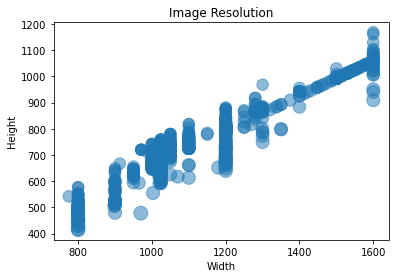

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Image Resolution')
ax.set_xlabel('Width')
ax.set_ylabel('Height')
pts = ax.scatter(all_imgs.width, all_imgs.height, s=all_imgs.a_ratio * 100, alpha=0.5)

## <a id="h2_3">Image Preprocessing</a>

As decided based on exploration of image sizes above, I will be destructively scaling images down.

However, before getting to that I'm going to return to the idea of dropping images per class to even out the class distribution. Now that I know I will be destructively resizing them I'll want to drop the images with an aspect ratio furthest from the target of 1.31 first since those would be subject to the most distortion.

In [9]:
# Sorting makes dropping largest simple
all_imgs.sort_values('a_ratio', inplace=True)

# Will drop to 100 instances per class
for cl in all_imgs['class'].unique():
    cl_view = all_imgs[all_imgs['class'] == cl]

    # End of list are largest ratios
    to_drop = cl_view.tail(cl_view.shape[0] - 100)

    all_imgs.drop(index=to_drop.index, inplace=True)

all_imgs.value_counts('class')

class
Airbus       100
Boeing       100
British      100
Canadair     100
Cessna       100
Douglas      100
Embraer      100
Fokker       100
Lockheed     100
McDonnell    100
de           100
dtype: int64

Finally it is time to resize the images. Taking the minimum aspect ratio of 1.31 and applying it to the minimum dimension of 414px in height means the target image size will be 542px $\times$ 414px 

In [10]:
dims_target = (542, 414)

# Images will be saved post-preprocessing to reduce data load time for future re-runs
processed_dir = f'{data_dir}/images_post'
if not os.path.isdir(processed_dir):
    os.mkdir(processed_dir)

    for fn in all_imgs.index:
        # Image names are 0 padded to 7 digits
        fn_true = f'{fn:07}'
        img = cv2.imread(f'{img_dir}/{fn_true}.jpg')

        # Remember to crop off 20px bottom banner
        img = img[:-20, :]
        img = cv2.resize(img, dims_target)

        cv2.imwrite(f'{processed_dir}/{fn_true}.jpg', img)


## <a id="h2_4">Direct Comparison</a>

The following code pulls 3 random sample images from each class for an initial direct visual comparison.

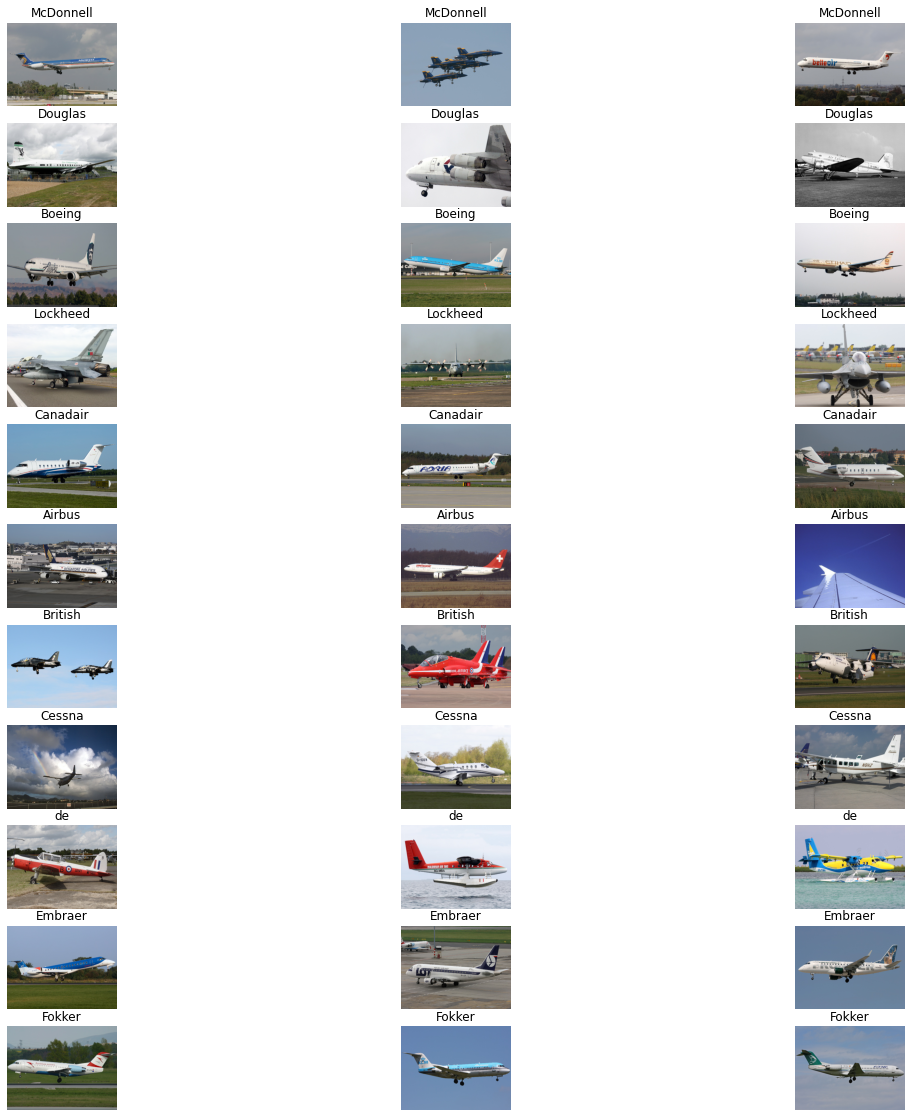

In [11]:
all_classes = all_imgs['class'].unique()

# Construct figure generally
fig = plt.figure(figsize=(20, 20))
per_class = 3
for i, cl in enumerate(all_classes):
    # 3 random samples of each class
    class_imgs = all_imgs[all_imgs['class'] == cl].index
    class_imgs = np.random.choice(class_imgs, per_class, replace=False)

    for j in range(per_class):
        ax = fig.add_subplot(len(all_classes), per_class, i*per_class + j + 1)

        # OpenCV uses BGR by default, matplotlib expects RGB
        img = cv2.imread(f'{processed_dir}/{class_imgs[j]:07}.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(cl)
        plt.axis('off')
plt.show()

It's clear from a quick visual inspection that the aircraft have fairly visually distinguishable features per class. This suggests to me it should be fine to process the images in greyscale - reducing the number of features (1 per pixel instead of 3 per pixel) for efficiency and reduced memory requirement.

## <a id="h2_5">Conversion to Pixel Data</a>

In order to process all class images for summary statistics I first group them into lists of $w \times h$ pixel matrices. As I'm working with greyscale images the element values represent the pixel shade at that coordinate.

In [12]:
all_class_ids = {cl: all_imgs[all_imgs['class'] == cl].index for cl in all_classes}

def read_all_img():
    class_imgs = {}
    for cl in all_class_ids:
        class_imgs[cl] = []

        for fn in all_class_ids[cl]:
            img = cv2.imread(f'{processed_dir}/{fn:07}.jpg', cv2.IMREAD_GRAYSCALE)
            
            class_imgs[cl].append(img)
            
    return class_imgs

all_class_imgs = read_all_img()

## <a id="h2_6">Average Images</a>

By averaging the pixel data for all of a given class, I can get a sense for the regions which are common to each class.

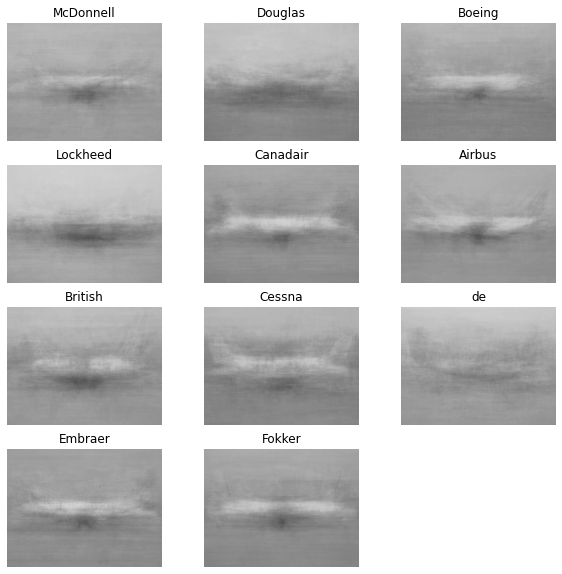

In [13]:
# Use function to avoid polluting global namespace
def average_img(image_set):
    avg = image_set[0]
    for i in range(len(image_set)):
        if i == 0:
            pass
        else:
            alpha = 1/(i + 1)
            beta = 1 - alpha
            avg = cv2.addWeighted(image_set[i], alpha, avg, beta, 0)
    return avg

# Flatten image sets to averages via comprehension
all_class_means = { cl: average_img(all_class_imgs[cl]) for cl in all_classes}

multi_plot(all_class_means, size=(10,10), rowlen=3)

It's clear from the averages that there's a lot of similarity in the features between classes since they all have some central "aircraft blob" feature cluster.

Yet there are noticable diferences, such as the shapes at the ends of the blobs and the thickness of the blobs.

The difference between the classes becomes clearer by taking the absolute difference between averaged images.

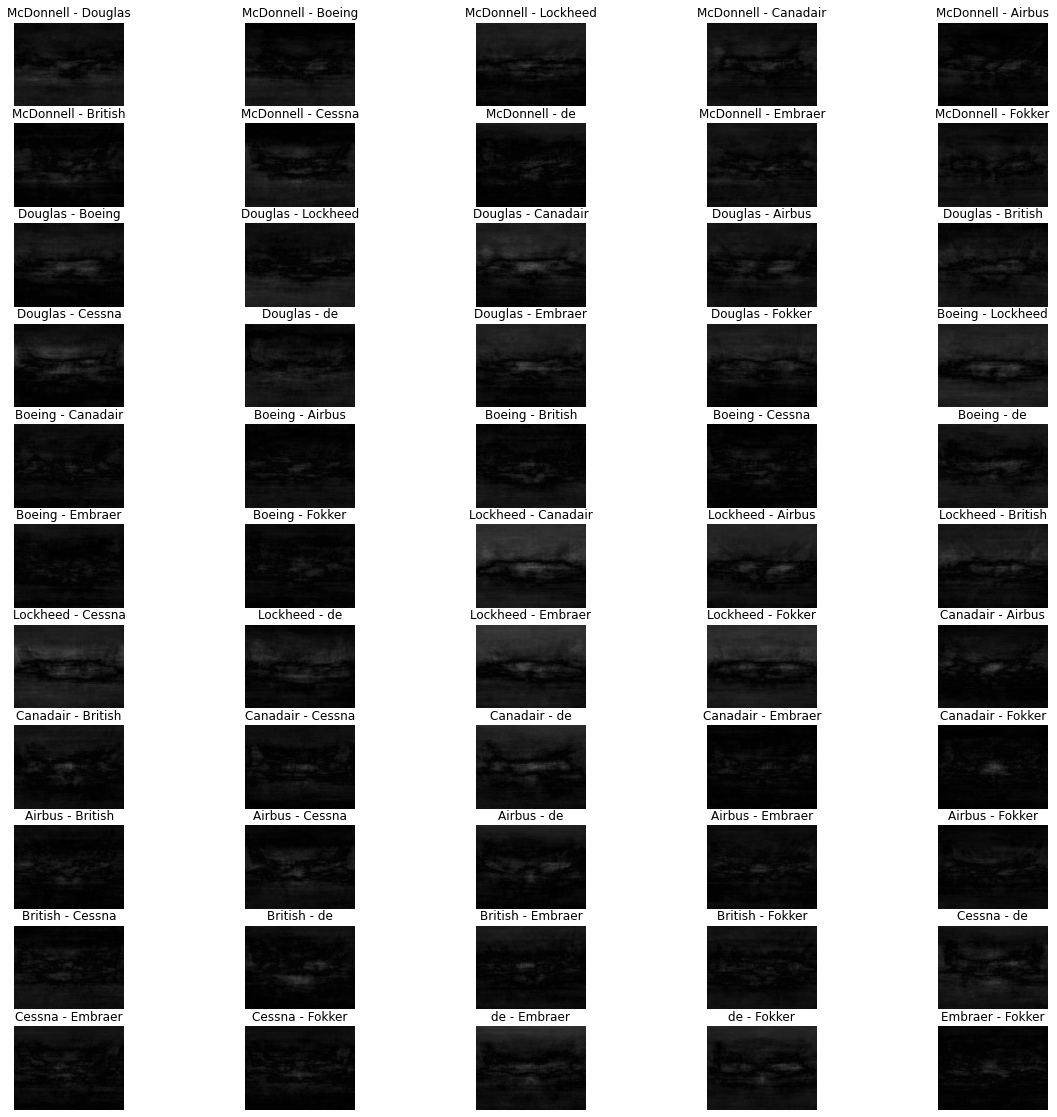

In [14]:
all_mean_combos = {}
for a, b in itertools.combinations(all_classes, 2):
    all_mean_combos[f'{a} - {b}'] = cv2.absdiff(all_class_means[a], all_class_means[b])

multi_plot(all_mean_combos, size=(20,20), rowlen=5)

Here the lighter pixels represent features of difference between the two class average images (with true white being 100% different and black being 0% different).

The amount of black in each image shows how similar the averages are, but there are light regions where we expect to see the aircraft which suggests they do have distinguishing features of various clarity between the classes (e.g. the Lockheed - Cessna comparison is much clearer than the Boeing - Airbus comparison).

## <a id="h2_7">Standard Deviation</a>

To get a sense of the pixel regions which vary the most in each class, the same reasoning of averaging can be applied, but instead taking the standard deviation. The resulting images aren't as clear, but here I can see a lot more varience in those lower left and right regions for the pollen carrying class. This reinforces my understanding of the data.

# <a id="ack">Acknowledgement</a>

- FGVC-Aircraft data set
    - Fine-Grained Visual Classification of Aircraft, S. Maji, J. Kannala, E. Rahtu, M. Blaschko, A. Vedaldi, [arXiv.org](https://arxiv.org/abs/1306.5151), 2013
- Image resizing resources
    - [https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly](https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly)
- Image data exploration resources
    - [https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)
    - [https://automaticaddison.com/how-to-blend-multiple-images-using-opencv/](https://automaticaddison.com/how-to-blend-multiple-images-using-opencv/)